In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import time

# Get the labels ready for the Model

In [3]:
labels = []
with open("labels.txt", "r") as f:
    labels = f.read().split("\n")

# Get the Model ready 
### https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 

In [4]:
config = "yolov3.cfg"
weights = "yolov3.weights"
net = cv2.dnn.readNet(weights, config)

layer_names = net.getLayerNames()
output_layers = []

for i in net.getUnconnectedOutLayers():
    output_layers.append(layer_names[i-1])
    
colors = np.random.uniform(0, 255, size=(len(labels), 3))

# Example using a single image

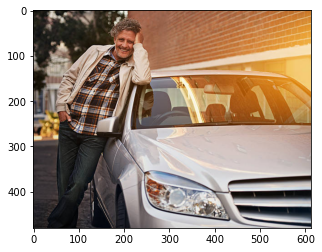

In [5]:
img = cv2.imread("man_and_car.jpeg")
height, width, channels = img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # CV default is BGR

In [6]:
blob = cv2.dnn.blobFromImage(img, 0.00392, (320, 320), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

def draw_boxes(outs, height, width):
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    return boxes, confidences, class_ids

boxes, confidences, class_ids = draw_boxes(outs, height, width)
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4) # removes noisy boxes

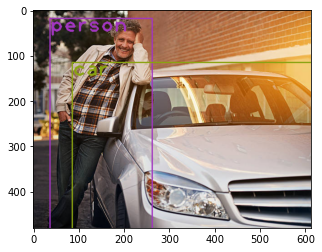

In [7]:
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(labels[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
        
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Example using webcam

In [11]:
cap = cv2.VideoCapture(0)
scale = 3
font = cv2.FONT_HERSHEY_PLAIN

ret, frame = cap.read()
height, width, channels = frame.shape

while True:
    ret, frame = cap.read()
    
    if round(time.time()) % 2 == 0:
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (220, 220), (0, 0, 0), True, crop=False) # reduce size to improve speed
        net.setInput(blob)
        outs = net.forward(output_layers)

        boxes, confidences, class_ids = draw_boxes(outs, height, width)
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4) # removes noisy boxes

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(labels[class_ids[i]])
            color = colors[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, label, (x, y + 30), font, 3, color, 3)

    cv2.imshow("easy vision", frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()